# Optical Tweezers 292 GUI

## Functionality:
- Connect to Optical Tweezers using NIDAQ Control software and drivers to gather data and analyze.

## Support

|           | Supports Functionality |
|-----------|--------------|
|Taking Sine|      Yes     |
|Graphing Sine|      Yes     |
|Taking Sawtooth|      Yes     |
|Graphing Sawtooth|      No     |
|Taking Power Spectrum|      No     |
|Graphing Power Spectrum|      No     |


## Guides:

GUI Documentation: [292 Optical Tweezers Documentation](https://docs.google.com/document/d/1UIyrJpPVibWfCxfNz_ZTX6MNZtwCGOgMLPl32wL9eTw/edit?usp=sharing)


## Contributors:
- Emma Li
- Ryland Birchmeier

In [2]:
%matplotlib notebook

import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt

import time
import sys
import glob
import math

from multiprocessing import Process
import threading
from threading import Thread

"""
Using IPython File Upload: 
https://github.com/peteut/ipython-file-upload
pip install fileupload
jupyter nbextension install --py fileupload
jupyter nbextension enable --py fileupload
"""
import io
from IPython.display import display
#import fileupload

from PyDAQmx import *
import ctypes
from ctypes import byref

import pickle

import PySimpleGUI as sg
# matplotlib tkinter canvas import
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import webbrowser

from PIL import Image, ImageTk, ImageSequence
# import keyboard
print("Imports Ran Successfully")
#################################################################################
#
# To get this working on a new machine you might need to:
#    * install the niDAQmx drivers from National Instruments
#    * install PyDAQmx ('pip install PyDAQmx' should do it)
#    * install pysimplegui ('pip install PySimpleGUI' or 'conda install -c conda-forge pysimplegui')
#
#################################################################################

Imports Ran Successfully


In [3]:
class GlobalVariables:
    gif_filename = "Loading (3).gif"
    save_folder = ""
    analyze_folder = ""
    volts_to_um = 2.58 # Recalibrate for Your Own Use!!
    viscosity = 8.9e-4
    radius_bead = 6.25e-7

    # sg.theme("BlueMono")
    # sg.theme("DarkTanBlue")
    sg.theme("DarkBlue")

    laser_power = 105
    trial_num = 0
    frequency = 12.5
    amplitude = 0.25
    num_trials = 6
    test_voltage = 5
    osc_num = 4
    samp_freq = 5000
    offset = 7.5
    waveform = 'Sine'
    test_axis = 'X-Axis'
    oscillation_axis = 'X-Axis'

    data_loader = None

    app_state = 0
    Running = True
    running_trials = False
    canvas_scrolled_to = 0


variables = GlobalVariables()

In [4]:
class DataLoader:
    opened_files = []
    grouped_files = [] # 2d array
    grouped_files_by_laser_power = [] # 3d array
    laser_powers = []

    
    '''
    @Params
    folder_path : String for the name of the directory containing the data to be analyzed
    
    ''' 
    def __init__(self, folder_path=variables.analyze_folder):
        self.folder_path = folder_path
        self.opened_files.clear()
        self.glob_data()
        self.grouped_files.clear()
        self.group_trials()
        self.grouped_files_by_laser_power.clear()
        self.group_groups_by_laser_power()
        self.laser_powers.clear()
        self.populate_laser_powers()

        
    '''
    @Params
    
    '''
    def glob_data(self):
        fls = glob.glob(self.folder_path+"/*")
        print(fls)
        for file_name in fls:
            file_opened = pickle.load(open(file_name,'rb'))
            self.opened_files.append(file_opened)
        print(f'{len(self.opened_files)} files opened')

    '''
    @Params
    opened_file : dictionary for individual trial storing params (e.g. axis, fs) and array of data points 
    '''
    def get_psd(self, opened_file):
        # Center Graph Around 0
        zero_calibrated_psd = opened_file['inputData_0'] - opened_file['inputData_0'].mean()
        zero_calibrated_psd = zero_calibrated_psd[(round(len(zero_calibrated_psd) * 12 / 16)):(round(len(zero_calibrated_psd) * 15 / 16))] # can change the multipliers if necessarry
        zero_calibrated_psd.sort()
        zero_calibrated_psd = abs(zero_calibrated_psd)

        # Find Amplitude
        counter = 0; num_data_points = 10
        for j in range(num_data_points):
            counter += zero_calibrated_psd[-j]
        return counter / num_data_points # aka average of most extreme 10 points


    def get_laser_power(self, opened_file):
        return opened_file['laser_power']

    def get_trial_num(self, opened_file):
        return opened_file['trial_num']

    def get_frequency(self, opened_file):
        return opened_file['frequency']

    def get_amplitude(self, opened_file):
        return opened_file['amplitude']

    def get_num_trials(self, opened_file):
        return opened_file['num_trials']

    def get_waveform(self, opened_file):
        return opened_file['waveform']

    def group_trials(self):
        for file in self.opened_files:
            appended = False
            if len(self.grouped_files) != 0:
                for grouped_set in self.grouped_files:
                    first_item_in_group = grouped_set[0]
                    if self.get_laser_power(first_item_in_group)==self.get_laser_power(file) and self.get_frequency(first_item_in_group)==self.get_frequency(file) and self.get_amplitude(first_item_in_group)==self.get_amplitude(file) and self.get_waveform(first_item_in_group)==self.get_waveform(file):
                        grouped_set.append(file)
                        appended = True
            if not appended:
                self.grouped_files.append([file])

        print(np.array(self.grouped_files).shape)

        
    '''
    @Params
    
    '''
    def group_groups_by_laser_power(self):
        for group in self.grouped_files:
            appended = False
            if len(self.grouped_files_by_laser_power) != 0:
                for laser_power_group in self.grouped_files_by_laser_power:
                    first_item_in_group = laser_power_group[0][0]
                    print(first_item_in_group)
                    print(group[0])
                    if self.get_laser_power(first_item_in_group) == self.get_laser_power(group[0]):
                        laser_power_group.append(group)
                        appended = True
            if not appended:
                self.grouped_files_by_laser_power.append([group])
        print(np.array(self.grouped_files_by_laser_power).shape)

    '''
    @Params
    
    '''
    def populate_laser_powers(self):
        for group in self.grouped_files_by_laser_power:
            self.laser_powers.append(self.get_laser_power(group[0][0]))
        print("Laser Powers: " + str(self.laser_powers))

    '''
    @Params
    grouped_files : 1D array containing data from one frequency
    
    '''
    def get_psd_average_std(self, grouped_files):
        psd_list = []
        for file in grouped_files:
            psd_list.append(self.get_psd(file))
        average_psd = np.mean(np.array(psd_list))
        std_psd = np.std(np.array(psd_list))
        return average_psd, std_psd

# Create Instance When Use

In [5]:
class Controller:
    x_piezo = "Dev2/ao0"  # The x-piezo is connected to AO0 (pin 12)
    y_piezo = "Dev2/ao1"  # The y-piezo is connected to AO1 (pin 13)
    inChannels = "Dev2/ai0, Dev2/ai1, Dev2/ai2, Dev2/ai3"
    num_input_channels = 4
    autoStart = 0
    dataLayout = DAQmx_Val_GroupByChannel
    fillMode = DAQmx_Val_GroupByChannel
    timeout = 10
    read = int32()
    sampsWritten = int32()

    saved_data = {}  # Initialize empty dictionary to store data

    '''
    @Params
    device : String of name of the channel connecting to the OT
    num_samps : int of samples per channel
    sampling_rate : float for rate of sampling per second
    tsk : Task to set up the connection between the GUI and the DAQ ? for outputs
    timing : boolean set True for oscillations 
    
    '''
    def setUpOutput(self, device, num_samps=20000, sampling_rate=1000, tsk=None, timing=True):
        '''
        Initialize the DAQ for sending analog outputs
        For waveforms, use timing=True
        For sending a single voltage, use timing=False
        Device is "Dev1/ao0", "Dev1/ao1", or whatever the right channel is
        '''
        if tsk is None:
            tsk = Task()
        tsk.CreateAOVoltageChan(device, "", 0.0, 10.0, DAQmx_Val_Volts,
                                None)  # sets up channel for output between 0 and 10 V
        if timing:
            tsk.CfgSampClkTiming("", sampling_rate, DAQmx_Val_Rising, DAQmx_Val_FiniteSamps, num_samps)
        return tsk

    '''
    @Params
    tsk : Task to set up the connection between the GUI and the DAQ? for inputs
    sampling_rate : float for rate of sampling per second
    num_samps : int of samples per channel
    
    '''
    def setUpInput(self, tsk=None, sampling_rate=1000, num_samps=20000):
        if tsk is None:
            tsk = Task()
        tsk.CreateAIVoltageChan(self.inChannels, "", DAQmx_Val_Cfg_Default, -10.0, 10.0, DAQmx_Val_Volts, None)
        tsk.CfgSampClkTiming("", sampling_rate, DAQmx_Val_Rising, DAQmx_Val_FiniteSamps, num_samps)
        return tsk


    '''
        @Params
        test_axis : axis to test (x or y)
        test_distance : volts to move (not perfect yet... but gets the test done)
    '''
    # Set the piezo stages to a certain position
    def test_move(self, test_axis, test_distance):
        print(test_distance)
        print(test_axis)
        axis = self.x_piezo
        if test_axis == 'Y-Axis':
            axis = self.y_piezo
        print(axis)
        to = self.setUpOutput(axis, timing=False)  # Use "timing=False" for sending a single voltage to piezo
        voltage = float(test_distance)  # read's the inputted voltage from textbox
        print(voltage)
        to.WriteAnalogScalarF64(1, 10.0, voltage, None)
        time.sleep(0.5)
        to.StopTask()
        print("Test Complete")

    '''
    @Params
    oscaxis : String detailing axis to be oscillated
    numosc : int of number of oscillations to be completed
    sampfreq : float for number of samples taken per sec
    oscfreq : float for the frequency (var)
    amp : float for amplitude of platform movement
    os : int of offset for graph 
    wf : String for type of wave
    
    '''
    def oscillate(self, oscaxis, numosc, sampfreq, oscfreq, amp, os, wf):
        print("-----------------------------------")
        print(oscaxis)
        print(numosc)
        print(sampfreq)
        print(oscfreq)
        print(amp)
        print(os)
        print(wf)
        print("-----------------------------------")
        axis = self.x_piezo
        # '-OscAxis-'
        # Check which axis to oscillate
        if oscaxis == 'Y-Axis':
            print("y")
            axis = self.y_piezo

        num_osc = float(numosc)  # number of oscillations (from textbox)
        fs = float(sampfreq)  # sampling frequency
        freq = float(oscfreq)  # frequency of oscillation
        time_oscillating = float(num_osc / freq)  # time spend oscillating
        samples_oscillating = time_oscillating * fs  # number of samples
        osc_freq_in_samples = freq / fs  # oscillation frequency in units of samples rather than Hz

        # This will be the argument of the sine or sawtooth or square wave function
        sine_argument = 2 * np.pi * osc_freq_in_samples * np.arange(samples_oscillating)

        amplitude = amp  # Amplitude of oscillation
        offset = os  # Offset
        waveform = wf  # kind of waveform, Sine, Square or Sawtooth

        if waveform == 'Square':
            data = amplitude * scipy.signal.square(sine_argument) + offset
        elif waveform == 'Sawtooth':
            data = amplitude * scipy.signal.sawtooth(sine_argument, width=0.5) + offset
        elif waveform == 'Sine':
            data = amplitude * np.sin(sine_argument) + offset
        else:
            print("BAD WAVE ARGUMENT")
            data = np.ones_like(sine_argument) * offset

        half_second_of_const = np.ones((int(0.5 * fs),),
                                       dtype=np.float64) * offset  # half-second pause before oscillations begin
        dataOut = np.hstack((half_second_of_const, data))  # Data to send to piezo

        inputData = np.zeros((len(dataOut) * self.num_input_channels,),
                             dtype=np.float64)  # Data to recieve from NI DAQ board

        to = self.setUpOutput(axis, num_samps=len(dataOut), sampling_rate=fs, timing=True)  # Output task
        ti = self.setUpInput(sampling_rate=fs, num_samps=len(dataOut))  # Input task

        ti.StartTask()
        to.WriteAnalogF64(len(dataOut), self.autoStart, self.timeout, self.dataLayout, dataOut, byref(self.sampsWritten), None)

        # Define processes that will start the input and output of the NI DAQ
        def outputProc():
            to.StartTask()

        def inputProc():
            ti.ReadAnalogF64(len(dataOut), self.timeout * 2, self.fillMode, inputData, len(inputData), byref(self.read), None)

        # Make a list of threads. One thread is for input, the other output
        thread_list = []
        thread_list.append(threading.Thread(target=outputProc))
        thread_list.append(threading.Thread(target=inputProc))

        for thread in thread_list:
            thread.start()

        time.sleep(time_oscillating + 0.5)
        time.sleep(1.0)
        to.StopTask()
        ti.StopTask()

        # Store the data in the dictionary "saved_data"
        self.saved_data['Fs'] = fs
        self.saved_data['axis'] = oscaxis
        # Added->
        self.saved_data['laser_power'] = variables.laser_power
        self.saved_data['trial_num'] = variables.trial_num
        self.saved_data['frequency'] = variables.frequency
        self.saved_data['amplitude'] = variables.amplitude
        self.saved_data['num_trials'] = variables.num_trials
        self.saved_data['waveform'] = variables.waveform
        # <-End Added
        self.saved_data['dataOut'] = dataOut
        self.saved_data['inputData_0'] = inputData[0:len(dataOut)]
        self.saved_data['inputData_1'] = inputData[len(dataOut):2 * len(dataOut)]
        self.saved_data['inputData_2'] = inputData[2 * len(dataOut):3 * len(dataOut)]
        self.saved_data['inputData_3'] = inputData[3 * len(dataOut):4 * len(dataOut)]

        print("oscasix = " + str(oscaxis))
        print("numosc = " + str(numosc))
        print("sampfreq = " + str(sampfreq))
        print("oscfreq = " + str(oscfreq))
        print("amp = " + str(amp))
        print("os = " + str(os))
        print("wf = " + str(wf))

        print(self.saved_data)
        print("data successfully collected")

    
    '''
        @Params
        save_location : folder to save data filepath
    '''
    def save_previous_data(self, save_location):
        pickle.dump(self.saved_data, open(
            save_location + f"/Oscillations_{variables.waveform}_LaserPower{variables.laser_power}ma_OscFreq{variables.frequency}Trial{variables.trial_num}.p",
            'wb'))
        print("Saved to: " + save_location)

controller = Controller()

In [6]:
class TkinterDataCollectionGraphing:

    figure_canvas_agg_take_data = None
    figure_canvas_agg_analyze_data_psd_velocity = None
    figure_canvas_agg_k_vs_laser_power = None
    k_values = []

    '''
        @Params
        figure_agg : Tkinter "FigureCanvasTkAgg" which holds a widget
    '''
    def delete_figure_agg(self, figure_agg):
        figure_agg.get_tk_widget().forget()
        plt.close('all')

    '''
        @Params
        canvas : tkinter canvas embed
        figure_canvas_agg : Tkinter "FigureCanvasTkAgg" which holds a widget
    '''
    # helper method to draw plt figure in canvas
    def draw_figure(self, canvas, figure_canvas_agg):
        figure_canvas_agg.draw()
        figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
        return figure_canvas_agg


    '''
        @Params
        window : Pysimplegui window
        key : key for canvas to draw to
    '''    
    def display_previous_trial_graph(self, window, key):
        plt.ioff()
        plt.figure()
        fig = plt.gcf()
        # Define the time array. We can do this as we know the sampling frequency.
        times = np.arange(0, len(controller.saved_data['dataOut'])) * (1. / controller.saved_data['Fs'])
        # saved_data is the global variable above oscillation method
        plt.cla()
        plt.plot(times, controller.saved_data['inputData_0'] - controller.saved_data['inputData_0'].mean(), label='Channel 0')
        plt.plot(times, controller.saved_data['inputData_2'] - controller.saved_data['inputData_2'].mean(), label='Channel 2')
        plt.legend(loc=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        #     plt.show(block=False)
        figure_canvas_agg = FigureCanvasTkAgg(fig, window[key].TKCanvas)
        self.draw_figure(window[key].TKCanvas, figure_canvas_agg)
        return figure_canvas_agg

    ''' 
        @Params
        window : Pysimplegui window
        key : key for canvas to draw to
        file_list_one_laser_power : 2d array with groups of data for one velocity per array
        data_loader : dataloader object (should use variables.data_loader unless have other reason)
        Note: Only use one waveform per graph!!
    '''
    def display_psd_vs_velocity_graph(self, window, key, file_list_one_laser_power, data_loader):
        waveform_used = file_list_one_laser_power[0][0]['waveform']
        if waveform_used == 'Sine':
            print("Sine Graphing...")
            # w = 2 * math.pi * file_list_one_laser_power['frequency']
            velocity_list_x = []
            psd_list_y = []
            psd_error_list_y = []

            # Populate PSD list and Error List
            for psd_list in file_list_one_laser_power:
                # Get average psd and standard devaition of psds for point and error bars
                average_psd, std_psd = data_loader.get_psd_average_std(psd_list)
                psd_list_y.append(average_psd); psd_error_list_y.append(std_psd)

            #Populate Velocity List
            for files in file_list_one_laser_power:
                # Get Frequency and Amplitude
                amplitude_group = files[0]['amplitude']
                frequency_group = files[0]['frequency']
                velocity_list_x.append((2 * math.pi * frequency_group)*amplitude_group*(1/variables.volts_to_um)*0.000001)

            print(velocity_list_x)
            print(psd_list_y)
            print(psd_error_list_y)

            # Create Plot
            plt.ioff()
            plt.figure()
            fig = plt.gcf()
            plt.cla()
            plt.xlabel('Velocity (m/s)')
            plt.ylabel('PSD (V)')
            plt.errorbar(velocity_list_x, psd_list_y, yerr=psd_error_list_y, fmt='o', color='black',
                         ecolor='lightgray', elinewidth=3, capsize=0);
            m1, b1 = np.polyfit(velocity_list_x, psd_list_y, 1)
            plt.plot(np.array(velocity_list_x), m1 * np.array(velocity_list_x) + b1)
            plt.title(f"{file_list_one_laser_power[0][0]['laser_power']}ma PSD(V) vs Velocity(m/s)")
            plt.scatter(velocity_list_x, psd_list_y)
            plt.show(block=False)

            figure_canvas_agg = FigureCanvasTkAgg(fig, window[key].TKCanvas)
            self.draw_figure(window[key].TKCanvas, figure_canvas_agg)
            return figure_canvas_agg

        elif waveform_used == 'Sawtooth':
            print("Sawtooth Graphing...")
            pass

        
    '''
        @Params
        window : Pysimplegui window
        key : canvas key
        data_loader : dataloader object (should use variables.data_loader unless have other reason)
    '''
    def display_k_vs_laser_power(self, window, key, data_loader):

        self.k_values = []

        def truncate(n, decimals=0):
            multiplier = 10 ** decimals
            return int(n * multiplier) / multiplier

        def populate_k_values(file_list_one_laser_power):
            velocity_list_x = []
            psd_list_y = []
            psd_error_list_y = []

            # Populate PSD list and Error List
            for psd_list in file_list_one_laser_power:
                # Get average psd and standard devaition of psds for point and error bars
                average_psd, std_psd = data_loader.get_psd_average_std(psd_list)
                psd_list_y.append(average_psd)
                psd_error_list_y.append(std_psd)

            # Populate Velocity List
            for files in file_list_one_laser_power:
                # Get Frequency and Amplitude
                amplitude_group = files[0]['amplitude']
                frequency_group = files[0]['frequency']
                velocity_list_x.append(
                    (2 * math.pi * frequency_group) * amplitude_group * (1 / variables.volts_to_um) * 0.000001)
            print(velocity_list_x)
            print(psd_list_y)
            slope, _ = np.polyfit(velocity_list_x, psd_list_y, 1)
            k_value = 6 * math.pi * variables.viscosity * variables.radius_bead*(1/slope)
            self.k_values.append(k_value)

        for file_list_one_laser_power_populate in data_loader.grouped_files_by_laser_power:
            print("K value generated")
            populate_k_values(file_list_one_laser_power_populate)
            print("k = " + str(self.k_values[-1]))
            
        # Create Plot
        plt.ioff()
        plt.figure()
        fig = plt.gcf()
        plt.cla()
        plt.ylabel('K values (N/V)')
        plt.xlabel('Laser Power (ma)')
        m1, b1 = np.polyfit(data_loader.laser_powers, self.k_values, 1)
        plt.plot(np.array(data_loader.laser_powers), m1 * np.array(data_loader.laser_powers) + b1)
        plt.title("K (N/V) vs Laser Power (ma)")
        plt.scatter(data_loader.laser_powers, self.k_values)
        plt.show(block=False)

        figure_canvas_agg = FigureCanvasTkAgg(fig, window[key].TKCanvas)
        self.draw_figure(window[key].TKCanvas, figure_canvas_agg)
        return figure_canvas_agg


    
tkinter_graphing = TkinterDataCollectionGraphing()

In [7]:
#####################Intro###############################################

intro_screen = [[sg.Image(filename=variables.gif_filename,
                          enable_events=True,
                          key="-IMAGE-")]]

####################Menu#################################################

title_screen_center_col = [[sg.Text("OT 292", size=(12, 1), font=("Verdana", 100), justification='center')],
                           [sg.Text("----------------", size=(12, 1), font=("Verdana", 100), justification="center")],
                           [sg.Button("Create New Dataset", font=("Verdana", 30)),
                            sg.Button("Analyze Previous Dataset", font=("Verdana", 30))],
                           [sg.Button("Manual", size=(15, 1), key = '-Manual-')]]
title_screen_bottom_row = [[]]
title_screen_layout = [
    [sg.Column(title_screen_center_col), sg.Column(title_screen_bottom_row, element_justification='center')]]

#####################Add New Dataset#####################################

backbutton_col = [[sg.Button("<-- Back", key='-Back1-')]]

new_dataset_center_col = [[sg.T("")],
                          [sg.Text("Choose a folder: "), sg.Input(key="-IN2-", change_submits=True, size=(50, 1)),
                           sg.FolderBrowse(key="-IN-")],
                          [sg.Button("Continue", size=(20, 1))]]
new_dataset_layout = [[sg.Column(backbutton_col), sg.Column(new_dataset_center_col, element_justification='center')]]

#####################Taking Data#########################################

amplitude_input = sg.InputText(key="-Amplitude-", default_text=(f"{variables.amplitude}"))
frequency_input = sg.InputText(key="-OscFreq-", default_text=(f"{variables.frequency}"))

backbutton_col1 = [[sg.Button("<-- Back", key='-Back2-')]]

data_left_col = [[sg.Text("Data Parameters", size=(20, 1), font=("Verdana", 30))],
                 [sg.Text("Oscillation Axis", size=(25, 1), font=("Verdana", 10)),
                  sg.Combo(['X-Axis', 'Y-Axis'], default_value='X-Axis', key='-OscAxis-')],
                 [sg.Text("Sampling Frequency (Hz)", size=(25, 1), font=("Verdana", 10)),
                  sg.InputText(key="-SampFreq-", default_text=(variables.samp_freq))],
                 [sg.Text("Amplitude (V)", size=(25, 1), font=("Verdana", 10)), amplitude_input],
                 [sg.Text("Oscillation Frequency (Hz)", size=(25, 1), font=("Verdana", 10)), frequency_input],
                 [sg.Text("Offset (For Graphing)", size=(25, 1), font=("Verdana", 10)),
                  sg.InputText(key="-Offset-", default_text=(variables.offset))],
                 [sg.Text("Waveform", size=(25, 1), font=("Verdana", 10)),
                  sg.Combo(['Sine', 'Sawtooth'], default_value=(variables.waveform), key='-Waveform-')],
                 [sg.Text("# of Oscillations", size=(25, 1), font=("Verdana", 10)),
                  sg.InputText(key="-OscNum-", default_text=(variables.osc_num))],
                 [sg.Text("----------------------------------------------------", size=(25, 1), font=("Verdana", 10))],
                 [sg.Text("Data Save Info", size=(25, 1), font=("Verdana", 30))],
                 [sg.Text("Laser Power (ma)", size=(25, 1), font=("Verdana", 10)),
                  sg.InputText(key="-LaserPower-", default_text=(f"{variables.laser_power}"))],
                 [sg.Button("Save Set Values")],
                 [sg.Text("----------------------------------------------------", size=(25, 1), font=("Verdana", 10))],
                 [sg.Text("Test Voltage", size=(25, 1), font=("Verdana", 30))],
                 [sg.Text("Text Axis", size=(25, 1), font=("Verdana", 10)),
                  sg.Combo(['X-Axis', 'Y-Axis'], default_value=(variables.test_axis), key='-TestAxis-')],
                 [sg.Text("Test Distance (V)", size=(25, 1), font=("Verdana", 10)),
                  sg.InputText(key="-TestVolts-", default_text=(variables.test_voltage))],
                 [sg.Button("Move Distance (Test)", size=(20, 1)), sg.Button("Reset Trial Number", size=(20, 1))],
                 ]

trial_text_field = sg.Text(f"Trial # {variables.trial_num}", size=(15, 1), font=("Verdana", 15))
amplitude_text_field = sg.Text(f"Amplitude = {variables.amplitude} V", size=(20, 1), font=("Verdana", 15))
frequency_text_field = sg.Text(f"Frequency = {variables.frequency} Hz", size=(20, 1), font=("Verdana", 15))
run_button = sg.Button("Start Trials", size=(20, 1))

data_middle_col = [[sg.Text("Run Trials", size=(0, 1), font=("Verdana", 30))],
                   [sg.Text("Vary Amplitude or Frequency (Velocity)", size=(35, 1), font=("Verdana", 10)),
                    sg.Combo(['Frequency', 'Amplitude'], default_value='Frequency', key='-FreqOrAmp-')],
                   [sg.Text("Vary Amount (Hz for Freq, V for Amp)", size=(31, 1), font=("Verdana", 10)),
                    sg.InputText(key="-VaryAmount-", default_text=("2.5"))],
                   [sg.Text("Trials Per Velocity", size=(15, 1), font=("Verdana", 10)),
                    sg.InputText(key="-NumTrialsPerVelocity-", default_text=("6"))],
                   [run_button],
                   [sg.Text("Currently On...", size=(15, 1), font=("Verdana", 30))],
                   [trial_text_field],
                   [amplitude_text_field],
                   [frequency_text_field]]

graph_canvas = sg.Canvas(key='figCanvas')

data_right_col = [[sg.Text("Previous Trial Graph", size=(0, 1), font=("Verdana", 30))],
                  [graph_canvas],
                  [sg.Button("Accept and Run Next Trail", size=(15, 1)), sg.Button("Redo Last Trial", size=(15, 1))],
                  ]

data_collect_layout = [
    [sg.Column(backbutton_col1), sg.Column(data_left_col, size=(400, 550)), sg.Column(data_middle_col),
     sg.Column(data_right_col)]]
print(len(data_collect_layout[0]))

########################Analyzing Data###############################################

backbutton_analyze = [[sg.Button("<-- Back", key='-BackAnalyze-')]]

scroller_canvas = sg.Canvas(key='figCanvasScroller')
psd_vs_velocity_graphs = [[sg.Text("PSD vs Velocity Graphs", size=(0, 1), font=("Verdana", 30))],
                          [scroller_canvas],
                          [sg.Button("<-Previous", size=(20, 1)), sg.Button("Next->", size=(20, 1))],
                          ]

k_laser_power_canvas = sg.Canvas(key='klaserpower')
k_value_text_field = sg.Text(f"K Values = {tkinter_graphing.k_values}", size=(80, 1), font=("Verdana", 10))
k_vs_laser_power_graphs = [[sg.Text("K vs Laser Power Graph", size=(0, 1), font=("Verdana", 30))],
                           [k_laser_power_canvas],
                           [k_value_text_field],
                           ]

data_analyze_layout = [[sg.Column(backbutton_analyze)], [sg.Column(psd_vs_velocity_graphs), sg.Column(k_vs_laser_power_graphs)]]
#########################################################################################
# Creates each window w/ relevant layout
window_load = sg.Window('OT 292 DAQ Control',
                        intro_screen,
                        default_element_size=(12, 1),
                        resizable=False, finalize=True)
window_load.Hide()

window_menu = sg.Window('OT 292 DAQ Control',
                        title_screen_layout,
                        default_element_size=(12, 1),
                        resizable=False, finalize=True)
window_menu.Hide()

window_new_dataset = sg.Window('OT 292 DAQ Control',
                               new_dataset_layout,
                               default_element_size=(12, 1),
                               resizable=False, finalize=True)
window_new_dataset.Hide()

window_collect_data = sg.Window('OT 292 DAQ Control',
                                data_collect_layout,
                                default_element_size=(12, 1),
                                resizable=False, finalize=True)
window_collect_data.Hide()

window_analyze_data = sg.Window('OT 292 DAQ Control',
                                data_analyze_layout,
                                default_element_size=(12, 1),
                                resizable=False, finalize=True)
window_analyze_data.Hide()

4


In [8]:
#####################################Main Loop########################################################
# 0 = loading
# 1 = menu
# 2 = new dataset (folder select)
# 3 = collect dataset
# 4 = analyze dataset (folder select)
# 5 = analyze previous dataset main page

'''
    Purpose: The Main Graphical Loop for Pysimplegui/Tkinter. This solely handels graphics 
    and does none of the processing, movements, etc.
'''
def main_loop():
    while variables.Running:
        # End program if user closes window or
        # presses the OK button

        # display intro/loading page
        if variables.app_state == 0:
            window_menu.Hide()
            window_new_dataset.Hide()
            window_collect_data.Hide()
            window_analyze_data.Hide()
            window_load.UnHide()
            event, values = window_load.read()
            for frame in ImageSequence.Iterator(Image.open(variables.gif_filename)):
                event, values = window_load.read(timeout=5)
                window_load['-IMAGE-'].update(data=ImageTk.PhotoImage(frame))
                if event == sg.WIN_CLOSED:
                    variables.Running = False
            variables.app_state = 1

        # display main menu page (includes Create New Dataset and Analyze Dataset Options + manual)
        elif variables.app_state == 1:
            window_load.Hide()
            window_new_dataset.Hide()
            window_collect_data.Hide()
            window_analyze_data.Hide()
            window_menu.UnHide()
            event, values = window_menu.read()
            if event == sg.WIN_CLOSED:
                variables.Running = False
                break
            elif event == "Create New Dataset":
                variables.app_state = 2
            elif event == "Analyze Previous Dataset":
                variables.app_state = 4
            elif event == "-Manual-":
                print("manual works")
                webbrowser.open_new(r'https://docs.google.com/document/d/1UIyrJpPVibWfCxfNz_ZTX6MNZtwCGOgMLPl32wL9eTw/edit?usp=sharing')

        # display new dataset page - define direction to the folder in which data will be saved
        elif variables.app_state == 2:
            window_load.Hide()
            window_menu.Hide()
            window_collect_data.Hide()
            window_analyze_data.Hide()
            window_new_dataset.UnHide()
            event, values = window_new_dataset.read()
            if event == sg.WIN_CLOSED:
                variables.Running = False
                break
            elif event == '-Back1-':
                variables.app_state -= 1
            # checks to ensure that the user provides a final destination before proceeding
            elif event == "Continue" and values['-IN-'] != "":
                print(values["-IN-"])
                variables.save_folder = values["-IN-"]
                variables.app_state = 3
            elif event == "Continue" and values['-IN-'] == "":
                print("No Folder Selected")

        # display collect data page
        elif variables.app_state == 3:
            window_load.Hide()
            window_menu.Hide()
            window_new_dataset.Hide()
            window_analyze_data.Hide()
            window_collect_data.UnHide()
            event, values = window_collect_data.read()
            if event == sg.WIN_CLOSED:
                variables.Running = False
                break
            elif event == '-Back2-':
                variables.app_state -= 1
            # saves the data collected for the specific trial to save_folder
            elif event == "Accept and Run Next Trail" and variables.running_trials:
                # Save Here

                controller.oscillate(variables.oscillation_axis, variables.osc_num, variables.samp_freq, variables.frequency, variables.amplitude, variables.offset, variables.waveform)
                ###Load and Display Data and save it###

                if tkinter_graphing.figure_canvas_agg_take_data != None:
                    tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_take_data)
                tkinter_graphing.figure_canvas_agg_take_data = tkinter_graphing.display_previous_trial_graph(window_collect_data, 'figCanvas')
                controller.save_previous_data(variables.save_folder)
                controller.saved_data = {}
                ###########################
                if variables.trial_num == variables.num_trials - 1:
                    variables.trial_num = 0
                    # increments whichever is being varied for the trials (default = frequency) by specified amount
                    if values['-FreqOrAmp-'] == "Frequency":
                        variables.frequency += float(values["-VaryAmount-"])
                    elif values['-FreqOrAmp-'] == "Amplitude":
                        variables.amplitude += float(values["-VaryAmount-"])
                    variables.running_trials = False
                else:
                    variables.trial_num += 1

            elif event == "Start Trials" and not variables.running_trials:
                if variables.num_trials != 0:
                    # Run Trials of set number
                    variables.running_trials = True
                    # params: oscaxis, numosc, sampfreq, oscfreq, amp, offset, waveform
                    controller.oscillate(variables.oscillation_axis, variables.osc_num, variables.samp_freq, variables.frequency, variables.amplitude, variables.offset, variables.waveform)

                    if tkinter_graphing.figure_canvas_agg_take_data != None:
                        tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_take_data)
                        print("Deleted")
                    tkinter_graphing.figure_canvas_agg_take_data = tkinter_graphing.display_previous_trial_graph(window_collect_data, 'figCanvas')
                    controller.save_previous_data(variables.save_folder)
                    controller.saved_data = {}

                    if variables.trial_num == variables.num_trials - 1:
                        variables.trial_num = 0
                        # increments whichever is being varied for the trials (default = frequency) by specified amount
                        if values['-FreqOrAmp-'] == "Frequency":
                            variables.frequency += float(values["-VaryAmount-"])
                        elif values['-FreqOrAmp-'] == "Amplitude":
                            variables.amplitude += float(values["-VaryAmount-"])
                        variables.running_trials = False
                else:
                    print("Don't do zero trials, plz")
                    
            elif event == "Start Trials" and not variables.running_trials:
                print(
                    'Trials Already Started. Finish Out with \"Accept and Run Next Trial\" or Click \"Reset Trial Number\".')
            elif event == "Move Distance (Test)":
                print("Testing...")
                controller.test_move(variables.test_axis, variables.test_voltage)

            elif event == "Redo Last Trial" and variables.running_trials:
                controller.oscillate(variables.oscillation_axis, variables.osc_num, variables.samp_freq, variables.frequency, variables.amplitude, variables.offset, variables.waveform)
                ###Load and Display Data and save it###

                if tkinter_graphing.figure_canvas_agg_take_data != None:
                    tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_take_data)
                    print("Deleted")
                tkinter_graphing.figure_canvas_agg_take_data = tkinter_graphing.display_previous_trial_graph(window_collect_data, 'figCanvas')
                controller.save_previous_data(variables.save_folder)
                controller.saved_data = {}
                print("Redo Last Trial")
            elif event == "Save Set Values":
                # saves inputted values for trial name
                variables.laser_power = int(values['-LaserPower-'])
                variables.frequency = float(values['-OscFreq-'])
                variables.amplitude = float(values['-Amplitude-'])
                variables.num_trials = int(values['-NumTrialsPerVelocity-'])
                variables.test_voltage = float(values['-TestVolts-'])
                variables.test_axis = values['-TestAxis-']
                variables.osc_num = int(values['-OscNum-'])
                variables.samp_freq = int(values['-SampFreq-'])
                variables.offset = float(values['-Offset-'])
                variables.waveform = values['-Waveform-']
                variables.oscillation_axis = values['-OscAxis-']
            elif event == "Reset Trial Number":
                variables.trial_num = 0
                variables.running_trials = False
            trial_text_field.Update(f"Trial # {variables.trial_num}")
            amplitude_text_field.Update(f"Amplitude = {variables.amplitude} V")
            frequency_text_field.Update(f"Frequency = {variables.frequency} Hz")
            frequency_input.Update(variables.frequency)
            amplitude_input.Update(variables.amplitude)
            values['-LaserPower-'] = variables.laser_power
            values['-OscFreq-'] = variables.frequency
            values['-Amplitude-'] = variables.amplitude
            values['-NumTrialsPerVelocity-'] = variables.num_trials
            values['TestVolts'] = variables.test_voltage
            values['-TestAxis-'] = variables.test_axis
            values['-OscNum-'] = variables.osc_num
            values['-SampFreq-'] = variables.samp_freq
            values['-Offset-'] = variables.offset
            values['-Waveform-'] = variables.waveform
            values['-OscAxis'] = variables.oscillation_axis

        elif variables.app_state == 4:
            window_load.Hide()
            window_menu.Hide()
            window_collect_data.Hide()
            window_analyze_data.Hide()
            window_new_dataset.UnHide()
            event, values = window_new_dataset.read()
            if event == sg.WIN_CLOSED:
                variables.Running = False
                break
            elif event == '-Back1-':
                variables.app_state = 1
            # checks to ensure that the user provides a final destination before proceeding
            elif event == "Continue" and values['-IN-'] != "":
                print(values["-IN-"])
                variables.analyze_folder = values["-IN-"]
                variables.data_loader = None
                variables.data_loader = DataLoader(variables.analyze_folder)
                if len(variables.data_loader.opened_files)!=0:
                    # Graph PSD vs Velocity
                    if tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity != None:
                        tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity)
                        print("Deleted")
                    tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity = tkinter_graphing.display_psd_vs_velocity_graph(
                        window_analyze_data, 'figCanvasScroller',
                        variables.data_loader.grouped_files_by_laser_power[variables.canvas_scrolled_to],
                        variables.data_loader)
                    # Graph K vs Laser Power
                    if tkinter_graphing.figure_canvas_agg_k_vs_laser_power != None:
                        tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_k_vs_laser_power)
                        print("Deleted")
                    tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(
                        window_analyze_data, 'klaserpower', variables.data_loader)
                    k_value_text_field.Update(f"K Values = {tkinter_graphing.k_values}")
                    variables.app_state = 5
                else:
                    print("No Data to Analyze!")
            elif event == "Continue" and values['-IN-'] == "":
                print("No Folder Selected")

        elif variables.app_state == 5:
            window_load.Hide()
            window_menu.Hide()
            window_collect_data.Hide()
            window_new_dataset.Hide()
            window_analyze_data.UnHide()
            event, values = window_analyze_data.read()


            if event == sg.WIN_CLOSED:
                variables.Running = False
                break
            elif event == "-BackAnalyze-":
                variables.app_state = 4
            elif event == "<-Previous" and variables.canvas_scrolled_to > 0:
                variables.canvas_scrolled_to -= 1
            elif event == "Next->" and variables.canvas_scrolled_to < len(variables.data_loader.grouped_files_by_laser_power)-1:
                print(variables.canvas_scrolled_to)
                print(len(variables.data_loader.grouped_files_by_laser_power))
                variables.canvas_scrolled_to += 1

            # Graph PSD vs Velocity
            if tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity != None:
                tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity)
                print("Deleted")
            tkinter_graphing.figure_canvas_agg_analyze_data_psd_velocity = tkinter_graphing.display_psd_vs_velocity_graph(
                window_analyze_data, 'figCanvasScroller',
                variables.data_loader.grouped_files_by_laser_power[variables.canvas_scrolled_to],
                variables.data_loader)

            # Graph K vs Laser Power
            if tkinter_graphing.figure_canvas_agg_k_vs_laser_power != None:
                tkinter_graphing.delete_figure_agg(tkinter_graphing.figure_canvas_agg_k_vs_laser_power)
                print("Deleted")
            tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(
                window_analyze_data, 'klaserpower', variables.data_loader)
            k_value_text_field.Update(f"K Values = {tkinter_graphing.k_values}")

    # quit()
    window_load.close()
    window_menu.close()
    window_new_dataset.close()
    window_collect_data.close()
    window_analyze_data.close()

C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1
['C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial0.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial1.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial2.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial3.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial4.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq30.0Trial0.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq30.0Trial1.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Osci

<IPython.core.display.Javascript object>


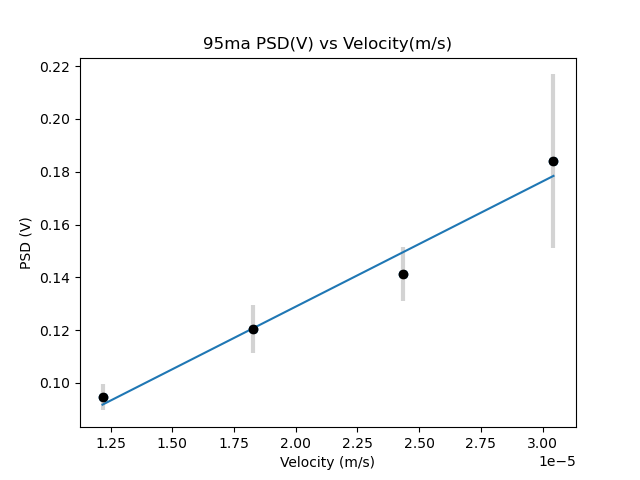

K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:217: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


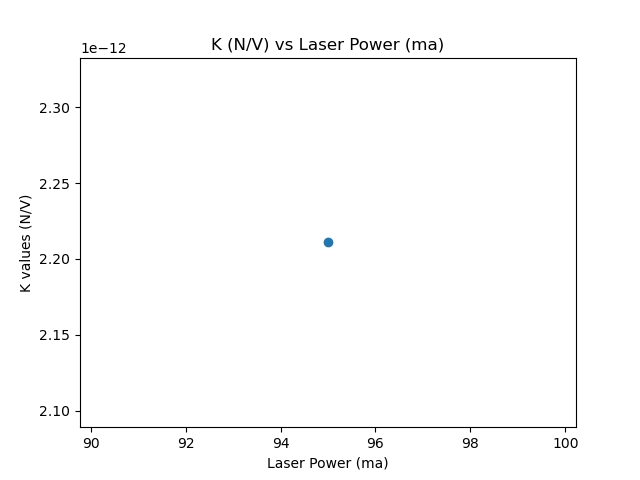

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


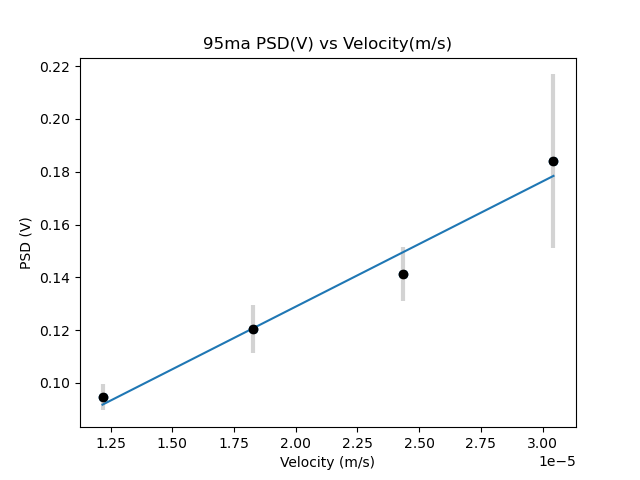

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


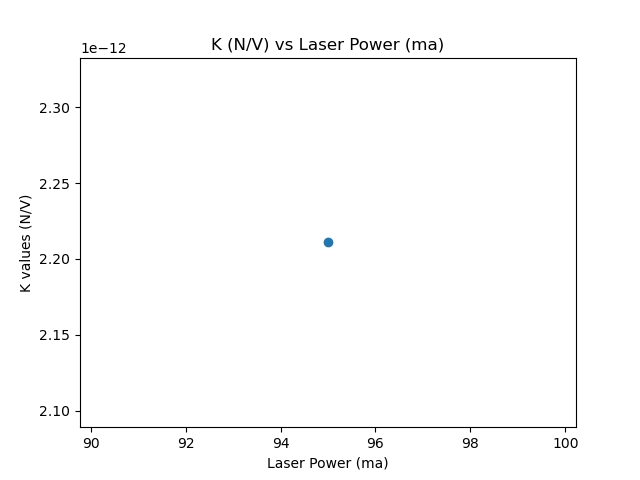

C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1
['C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial0.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial1.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial2.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial3.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq20.0Trial4.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq30.0Trial0.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Oscillations_Sine_LaserPower95ma_OscFreq30.0Trial1.p', 'C:/Users/Physics/Downloads/Phys381-Spring2019-master/OT/DemoData1\\Osci

<IPython.core.display.Javascript object>


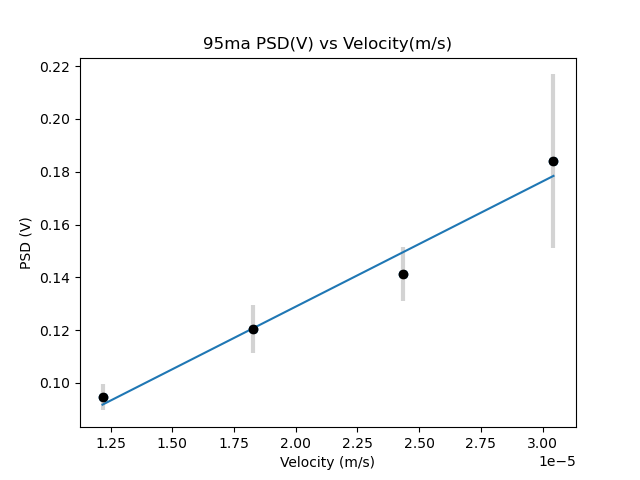

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:217: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


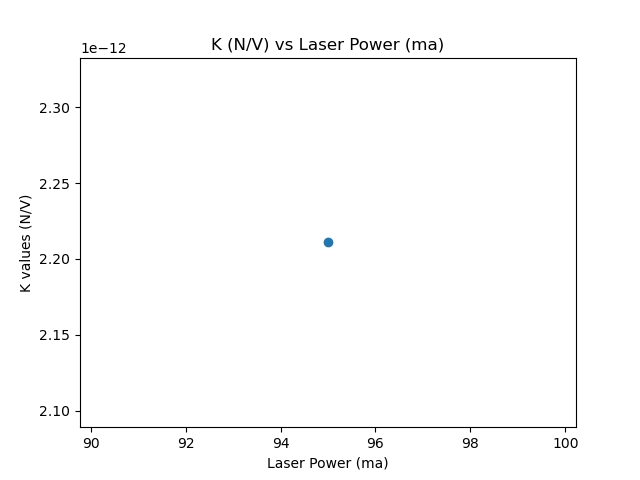

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


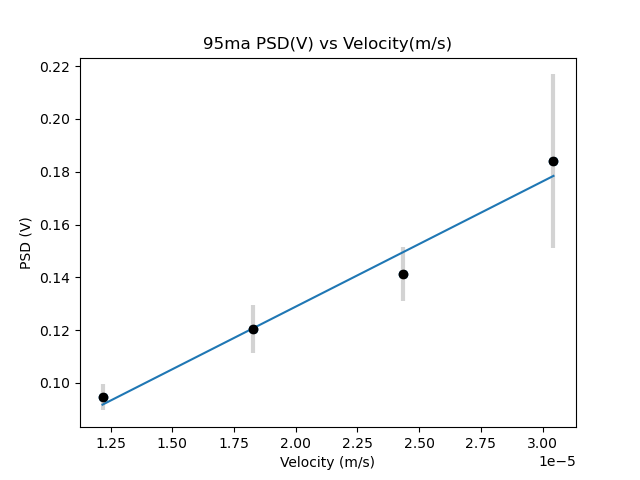

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


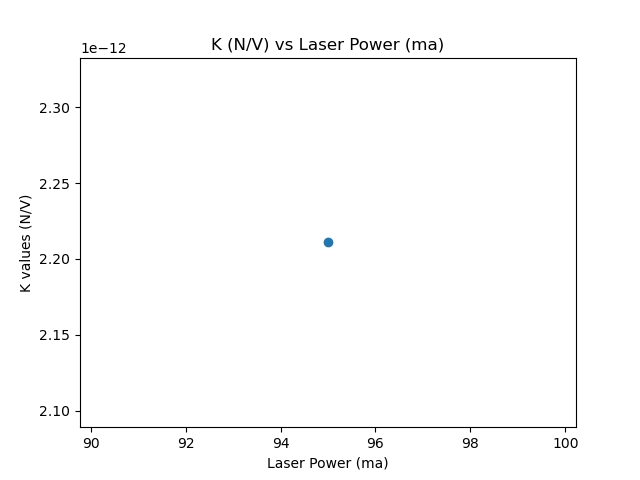

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


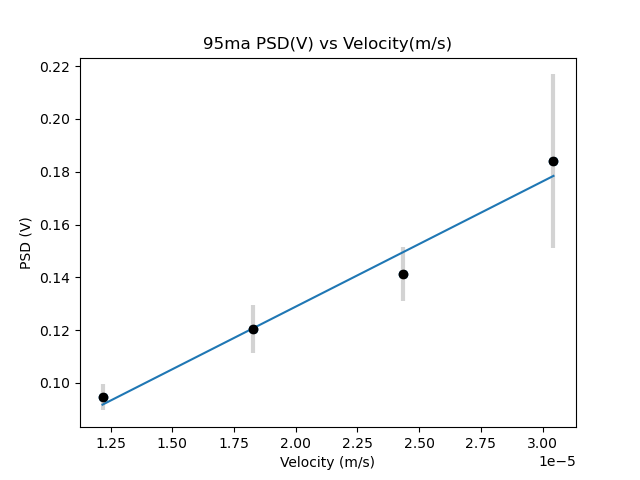

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


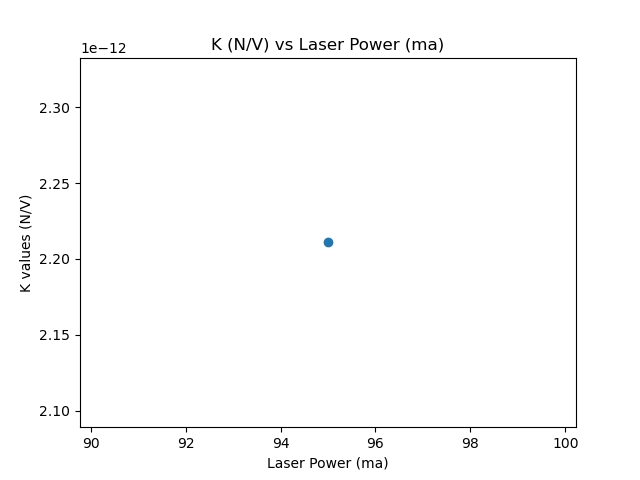

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


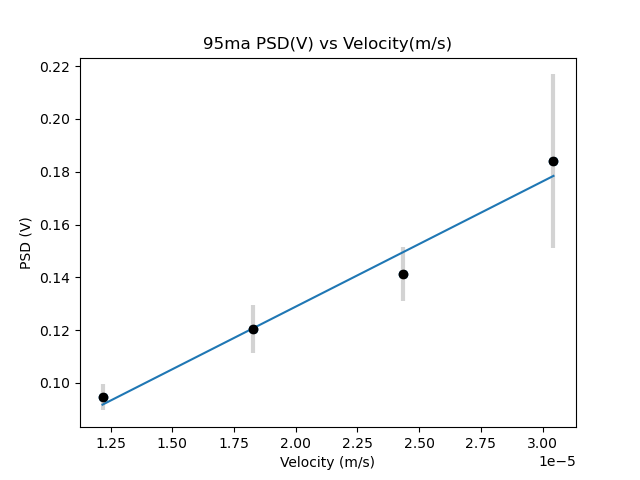

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


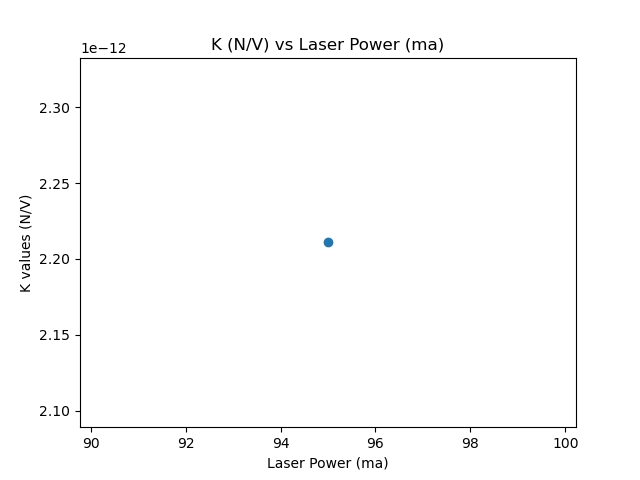

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


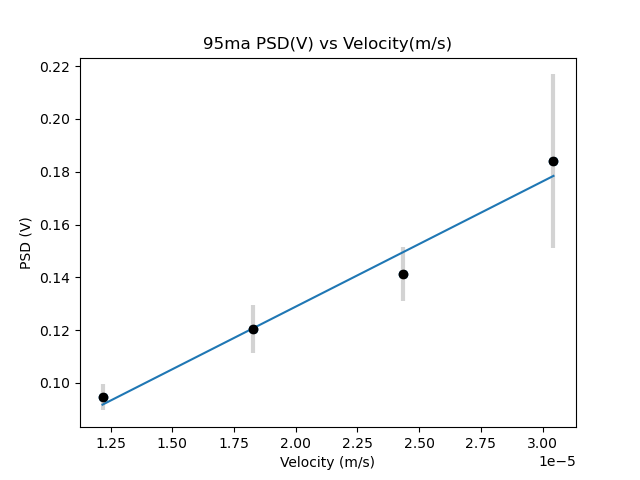

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


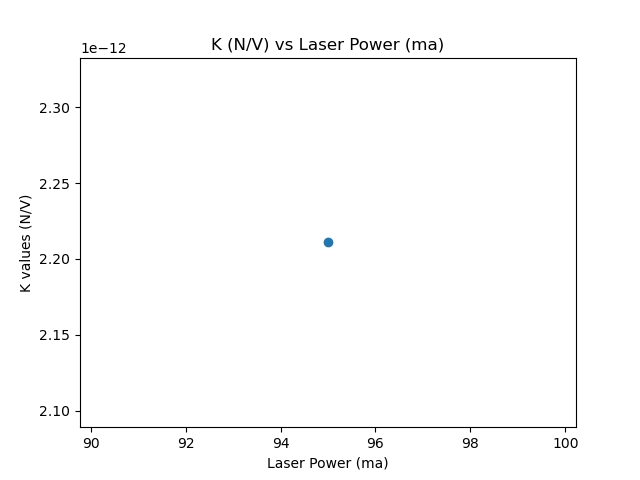

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


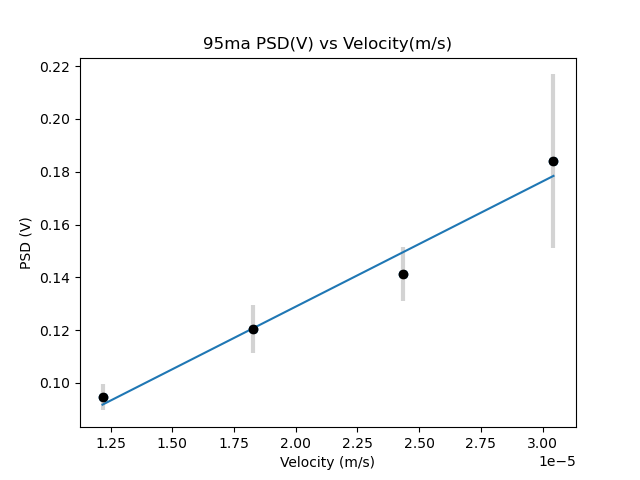

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


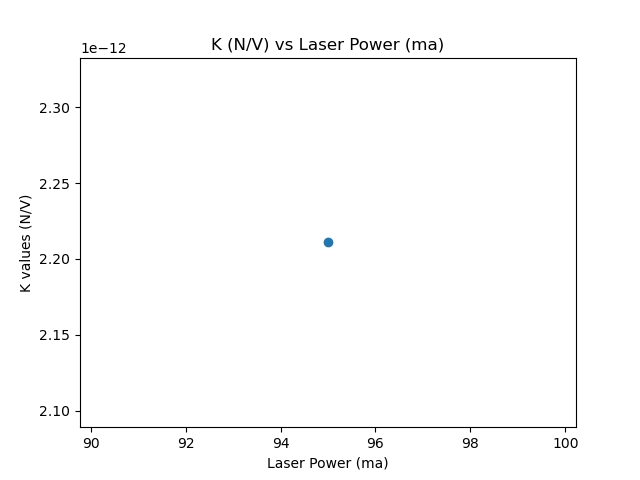

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


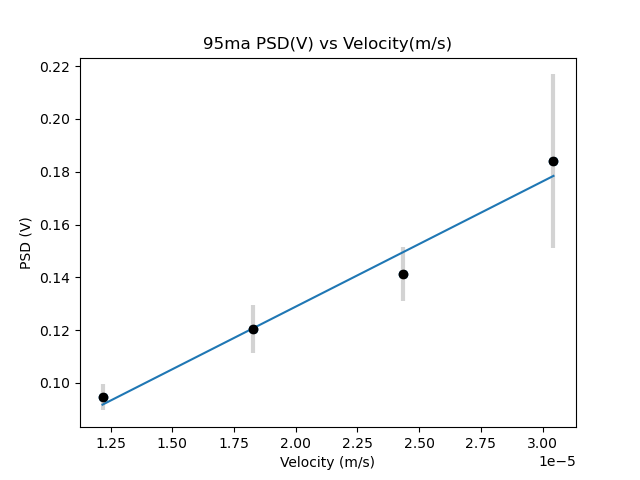

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


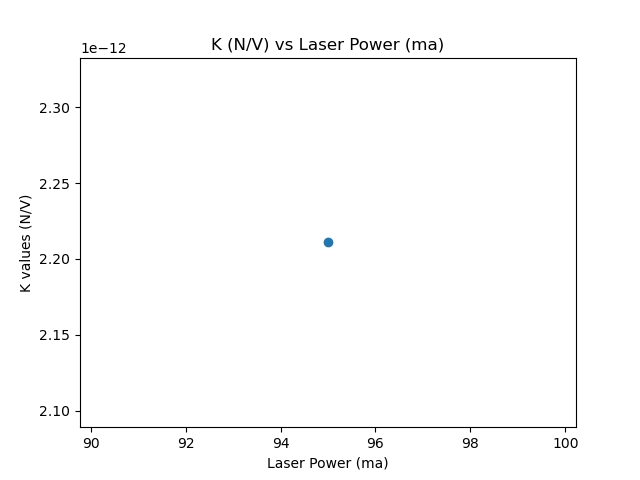

Deleted
Sine Graphing...
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
[0.005091167879793952, 0.009099991713904325, 0.010152576220775722, 0.03286453500344609]


<IPython.core.display.Javascript object>


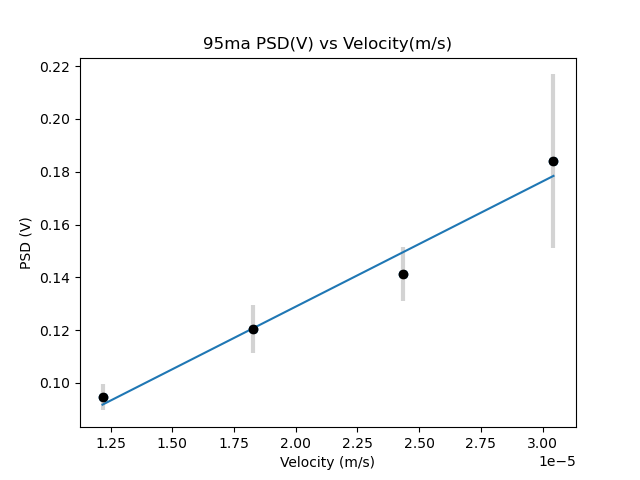

Deleted
K value generated
[1.2176715711588343e-05, 1.8265073567382514e-05, 2.4353431423176686e-05, 3.044178927897086e-05]
[0.0946973207809759, 0.12041699109913888, 0.14130288975608046, 0.18398014113364783]
k = 2.2109190902998278e-12


<ipython-input-8-07d4e16447be>:260: RankWarning: Polyfit may be poorly conditioned
  tkinter_graphing.figure_canvas_agg_k_vs_laser_power = tkinter_graphing.display_k_vs_laser_power(


<IPython.core.display.Javascript object>


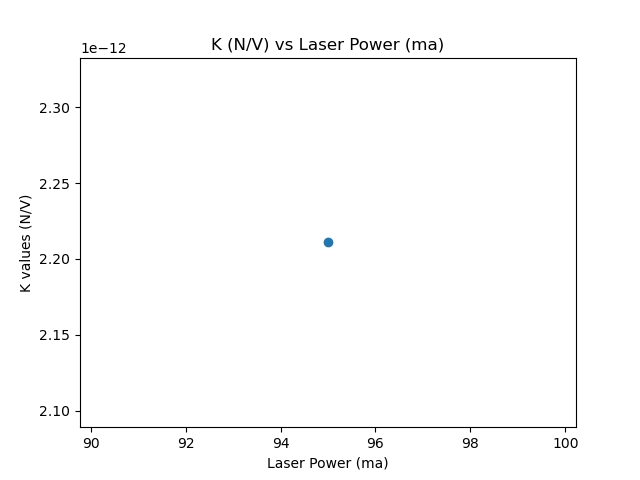

In [9]:
if __name__ == '__main__':
    main_loop()